In [1]:
#!/usr/bin/env python
#
# %BANNER_BEGIN%
# ---------------------------------------------------------------------
# %COPYRIGHT_BEGIN%
#
#  Magic Leap, Inc. ("COMPANY") CONFIDENTIAL
#
#  Unpublished Copyright (c) 2018
#  Magic Leap, Inc., All Rights Reserved.
#
# NOTICE:  All information contained herein is, and remains the property
# of COMPANY. The intellectual and technical concepts contained herein
# are proprietary to COMPANY and may be covered by U.S. and Foreign
# Patents, patents in process, and are protected by trade secret or
# copyright law.  Dissemination of this information or reproduction of
# this material is strictly forbidden unless prior written permission is
# obtained from COMPANY.  Access to the source code contained herein is
# hereby forbidden to anyone except current COMPANY employees, managers
# or contractors who have executed Confidentiality and Non-disclosure
# agreements explicitly covering such access.
#
# The copyright notice above does not evidence any actual or intended
# publication or disclosure  of  this source code, which includes
# information that is confidential and/or proprietary, and is a trade
# secret, of  COMPANY.   ANY REPRODUCTION, MODIFICATION, DISTRIBUTION,
# PUBLIC  PERFORMANCE, OR PUBLIC DISPLAY OF OR THROUGH USE  OF THIS
# SOURCE CODE  WITHOUT THE EXPRESS WRITTEN CONSENT OF COMPANY IS
# STRICTLY PROHIBITED, AND IN VIOLATION OF APPLICABLE LAWS AND
# INTERNATIONAL TREATIES.  THE RECEIPT OR POSSESSION OF  THIS SOURCE
# CODE AND/OR RELATED INFORMATION DOES NOT CONVEY OR IMPLY ANY RIGHTS
# TO REPRODUCE, DISCLOSE OR DISTRIBUTE ITS CONTENTS, OR TO MANUFACTURE,
# USE, OR SELL ANYTHING THAT IT  MAY DESCRIBE, IN WHOLE OR IN PART.
#
# %COPYRIGHT_END%
# ----------------------------------------------------------------------
# %AUTHORS_BEGIN%
#
#  Originating Authors: Daniel DeTone (ddetone)
#                       Tomasz Malisiewicz (tmalisiewicz)
#
# %AUTHORS_END%
# --------------------------------------------------------------------*/
# %BANNER_END%


import argparse
import glob
import numpy as np
import os
import time

import cv2
import torch
%pylab inline

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

# Jet colormap for visualization.
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])

class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    return semi, desc


class SuperPointFrontend(object):
  """ Wrapper around pytorch net to help with pre and post image processing. """
  def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
               cuda=False):
    self.name = 'SuperPoint'
    self.cuda = cuda
    self.nms_dist = nms_dist
    self.conf_thresh = conf_thresh
    self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
    self.cell = 8 # Size of each output cell. Keep this fixed.
    self.border_remove = 4 # Remove points this close to the border.

    # Load the network in inference mode.
    self.net = SuperPointNet()
    if cuda:
      # Train on GPU, deploy on GPU.
      self.net.load_state_dict(torch.load(weights_path))
      self.net = self.net.cuda()
    else:
      # Train on GPU, deploy on CPU.
      self.net.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
    self.net.eval()

  def nms_fast(self, in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T
  
    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.
  
    Grid Value Legend:
    -1 : Kept.
     0 : Empty or suppressed.
     1 : To be processed (converted to either kept or supressed).
  
    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.
  
    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds

  def run(self, img):
    """ Process a numpy image to extract points and descriptors.
    Input
      img - HxW numpy float32 input image in range [0,1].
    Output
      corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      desc - 256xN numpy array of corresponding unit normalized descriptors.
      heatmap - HxW numpy heatmap in range [0,1] of point confidences.
      """
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    H, W = img.shape[0], img.shape[1]
    inp = img.copy()
    inp = (inp.reshape(1, H, W))
    inp = torch.from_numpy(inp)
    inp = torch.autograd.Variable(inp).view(1, 1, H, W)
    if self.cuda:
      inp = inp.cuda()
    # Forward pass of network.
    outs = self.net.forward(inp)
    semi, coarse_desc = outs[0], outs[1]
    # Convert pytorch -> numpy.
    semi = semi.data.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / self.cell)
    Wc = int(W / self.cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell])
    xs, ys = np.where(heatmap >= self.conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = self.border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    # --- Process descriptor.
    D = coarse_desc.shape[1]
    if pts.shape[1] == 0:
      desc = np.zeros((D, 0))
    else:
      # Interpolate into descriptor map using 2D point locations.
      samp_pts = torch.from_numpy(pts[:2, :].copy())
      samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
      samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
      samp_pts = samp_pts.transpose(0, 1).contiguous()
      samp_pts = samp_pts.view(1, 1, -1, 2)
      samp_pts = samp_pts.float()
      if self.cuda:
        samp_pts = samp_pts.cuda()
      desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
      desc = desc.data.cpu().numpy().reshape(D, -1)
      desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc, heatmap


class PointTracker(object):
  """ Class to manage a fixed memory of points and descriptors that enables
  sparse optical flow point tracking.

  Internally, the tracker stores a 'tracks' matrix sized M x (2+L), of M
  tracks with maximum length L, where each row corresponds to:
  row_m = [track_id_m, avg_desc_score_m, point_id_0_m, ..., point_id_L-1_m].
  """

  def __init__(self, max_length, nn_thresh):
    if max_length < 2:
      raise ValueError('max_length must be greater than or equal to 2.')
    self.maxl = max_length
    self.nn_thresh = nn_thresh
    self.all_pts = []
    for n in range(self.maxl):
      self.all_pts.append(np.zeros((2, 0)))
    self.last_desc = None
    self.tracks = np.zeros((0, self.maxl+2))
    self.track_count = 0
    self.max_score = 9999

  def nn_match_two_way(self, desc1, desc2, nn_thresh):
    """
    Performs two-way nearest neighbor matching of two sets of descriptors, such
    that the NN match from descriptor A->B must equal the NN match from B->A.

    Inputs:
      desc1 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      desc2 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      nn_thresh - Optional descriptor distance below which is a good match.

    Returns:
      matches - 3xL numpy array, of L matches, where L <= N and each column i is
                a match of two descriptors, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, match_score]^T
    """
    assert desc1.shape[0] == desc2.shape[0]
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
      return np.zeros((3, 0))
    if nn_thresh < 0.0:
      raise ValueError('\'nn_thresh\' should be non-negative')
    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2-2*np.clip(dmat, -1, 1))
    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    # Threshold the NN matches.
    keep = scores < nn_thresh
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    # Get the surviving point indices.
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    # Populate the final 3xN match data structure.
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    return matches

  def get_offsets(self):
    """ Iterate through list of points and accumulate an offset value. Used to
    index the global point IDs into the list of points.

    Returns
      offsets - N length array with integer offset locations.
    """
    # Compute id offsets.
    offsets = []
    offsets.append(0)
    for i in range(len(self.all_pts)-1): # Skip last camera size, not needed.
      offsets.append(self.all_pts[i].shape[1])
    offsets = np.array(offsets)
    offsets = np.cumsum(offsets)
    return offsets

  def update(self, pts, desc):
    """ Add a new set of point and descriptor observations to the tracker.

    Inputs
      pts - 3xN numpy array of 2D point observations.
      desc - DxN numpy array of corresponding D dimensional descriptors.
    """
    if pts is None or desc is None:
      print('PointTracker: Warning, no points were added to tracker.')
      return
    assert pts.shape[1] == desc.shape[1]
    # Initialize last_desc.
    if self.last_desc is None:
      self.last_desc = np.zeros((desc.shape[0], 0))
    # Remove oldest points, store its size to update ids later.
    remove_size = self.all_pts[0].shape[1]
    self.all_pts.pop(0)
    self.all_pts.append(pts)
    # Remove oldest point in track.
    self.tracks = np.delete(self.tracks, 2, axis=1)
    # Update track offsets.
    for i in range(2, self.tracks.shape[1]):
      self.tracks[:, i] -= remove_size
    self.tracks[:, 2:][self.tracks[:, 2:] < -1] = -1
    offsets = self.get_offsets()
    # Add a new -1 column.
    self.tracks = np.hstack((self.tracks, -1*np.ones((self.tracks.shape[0], 1))))
    # Try to append to existing tracks.
    matched = np.zeros((pts.shape[1])).astype(bool)
    matches = self.nn_match_two_way(self.last_desc, desc, self.nn_thresh)
    for match in matches.T:
      # Add a new point to it's matched track.
      id1 = int(match[0]) + offsets[-2]
      id2 = int(match[1]) + offsets[-1]
      found = np.argwhere(self.tracks[:, -2] == id1)
      if found.shape[0] > 0:
        matched[int(match[1])] = True
        row = int(found)
        self.tracks[row, -1] = id2
        if self.tracks[row, 1] == self.max_score:
          # Initialize track score.
          self.tracks[row, 1] = match[2]
        else:
          # Update track score with running average.
          # NOTE(dd): this running average can contain scores from old matches
          #           not contained in last max_length track points.
          track_len = (self.tracks[row, 2:] != -1).sum() - 1.
          frac = 1. / float(track_len)
          self.tracks[row, 1] = (1.-frac)*self.tracks[row, 1] + frac*match[2]
    # Add unmatched tracks.
    new_ids = np.arange(pts.shape[1]) + offsets[-1]
    new_ids = new_ids[~matched]
    new_tracks = -1*np.ones((new_ids.shape[0], self.maxl + 2))
    new_tracks[:, -1] = new_ids
    new_num = new_ids.shape[0]
    new_trackids = self.track_count + np.arange(new_num)
    new_tracks[:, 0] = new_trackids
    new_tracks[:, 1] = self.max_score*np.ones(new_ids.shape[0])
    self.tracks = np.vstack((self.tracks, new_tracks))
    self.track_count += new_num # Update the track count.
    # Remove empty tracks.
    keep_rows = np.any(self.tracks[:, 2:] >= 0, axis=1)
    self.tracks = self.tracks[keep_rows, :]
    # Store the last descriptors.
    self.last_desc = desc.copy()
    return

  def get_tracks(self, min_length):
    """ Retrieve point tracks of a given minimum length.
    Input
      min_length - integer >= 1 with minimum track length
    Output
      returned_tracks - M x (2+L) sized matrix storing track indices, where
        M is the number of tracks and L is the maximum track length.
    """
    if min_length < 1:
      raise ValueError('\'min_length\' too small.')
    valid = np.ones((self.tracks.shape[0])).astype(bool)
    good_len = np.sum(self.tracks[:, 2:] != -1, axis=1) >= min_length
    # Remove tracks which do not have an observation in most recent frame.
    not_headless = (self.tracks[:, -1] != -1)
    keepers = np.logical_and.reduce((valid, good_len, not_headless))
    returned_tracks = self.tracks[keepers, :].copy()
    return returned_tracks

  def draw_tracks(self, out, tracks):
    """ Visualize tracks all overlayed on a single image.
    Inputs
      out - numpy uint8 image sized HxWx3 upon which tracks are overlayed.
      tracks - M x (2+L) sized matrix storing track info.
    """
    # Store the number of points per camera.
    pts_mem = self.all_pts
    N = len(pts_mem) # Number of cameras/images.
    # Get offset ids needed to reference into pts_mem.
    offsets = self.get_offsets()
    # Width of track and point circles to be drawn.
    stroke = 1
    # Iterate through each track and draw it.
    for track in tracks:
      clr = myjet[int(np.clip(np.floor(track[1]*10), 0, 9)), :]*255
      for i in range(N-1):
        if track[i+2] == -1 or track[i+3] == -1:
          continue
        offset1 = offsets[i]
        offset2 = offsets[i+1]
        idx1 = int(track[i+2]-offset1)
        idx2 = int(track[i+3]-offset2)
        pt1 = pts_mem[i][:2, idx1]
        pt2 = pts_mem[i+1][:2, idx2]
        p1 = (int(round(pt1[0])), int(round(pt1[1])))
        p2 = (int(round(pt2[0])), int(round(pt2[1])))
        cv2.line(out, p1, p2, clr, thickness=stroke, lineType=16)
        # Draw end points of each track.
        if i == N-2:
          clr2 = (255, 0, 0)
          cv2.circle(out, p2, stroke, clr2, -1, lineType=16)

class VideoStreamer(object):
  """ Class to help process image streams. Three types of possible inputs:"
    1.) USB Webcam.
    2.) A directory of images (files in directory matching 'img_glob').
    3.) A video file, such as an .mp4 or .avi file.
  """
  def __init__(self, basedir, camid, height, width, skip, img_glob):
    self.cap = []
    self.camera = False
    self.video_file = False
    self.listing = []
    self.sizer = [height, width]
    self.i = 0
    self.skip = skip
    self.maxlen = 1000000
    # If the "basedir" string is the word camera, then use a webcam.
    if basedir == "camera/" or basedir == "camera":
      print('==> Processing Webcam Input.')
      self.cap = cv2.VideoCapture(camid)
      self.listing = range(0, self.maxlen)
      self.camera = True
    else:
      # Try to open as a video.
      self.cap = cv2.VideoCapture(basedir)
      lastbit = basedir[-4:len(basedir)]
      if (type(self.cap) == list or not self.cap.isOpened()) and (lastbit == '.mp4'):
        raise IOError('Cannot open movie file')
      elif type(self.cap) != list and self.cap.isOpened() and (lastbit != '.txt'):
        print('==> Processing Video Input.')
        num_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.listing = range(0, num_frames)
        self.listing = self.listing[::self.skip]
        self.camera = True
        self.video_file = True
        self.maxlen = len(self.listing)
      else:
        print('==> Processing Image Directory Input.')
        search = os.path.join(basedir, img_glob)
        self.listing = glob.glob(search)
        self.listing.sort()
        self.listing = self.listing[::self.skip]
        self.maxlen = len(self.listing)
        if self.maxlen == 0:
          raise IOError('No images were found (maybe bad \'--img_glob\' parameter?)')

  def read_image(self, impath, img_size):
    """ Read image as grayscale and resize to img_size.
    Inputs
      impath: Path to input image.
      img_size: (W, H) tuple specifying resize size.
    Returns
      grayim: float32 numpy array sized H x W with values in range [0, 1].
    """
    grayim = cv2.imread(impath, 0)
    if grayim is None:
      raise Exception('Error reading image %s' % impath)
    # Image is resized via opencv.
    interp = cv2.INTER_AREA
    grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)
    grayim = (grayim.astype('float32') / 255.)
    return grayim

  def next_frame(self):
    """ Return the next frame, and increment internal counter.
    Returns
       image: Next H x W image.
       status: True or False depending whether image was loaded.
    """
    if self.i == self.maxlen:
      return (None, False)
    if self.camera:
      ret, input_image = self.cap.read()
      if ret is False:
        print('VideoStreamer: Cannot get image from camera (maybe bad --camid?)')
        return (None, False)
      if self.video_file:
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.listing[self.i])
      input_image = cv2.resize(input_image, (self.sizer[1], self.sizer[0]),
                               interpolation=cv2.INTER_AREA)
      input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
      input_image = input_image.astype('float')/255.0
    else:
      image_file = self.listing[self.i]
      input_image = self.read_image(image_file, self.sizer)
    # Increment internal counter.
    self.i = self.i + 1
    input_image = input_image.astype('float32')
    return (input_image, True)


Populating the interactive namespace from numpy and matplotlib


In [42]:
class VideoStablization():
    def __init__(self):
        self.superpt = SuperPointFrontend(weights_path='E:/Masterzz/5152-ComputerVision/Project/superpoint/SuperPointPretrainedNetwork/superpoint_v1.pth',
                      nms_dist=4,
                      conf_thresh=0.05,
                      nn_thresh=0.7,
                      cuda=False)
        self.pTracker = PointTracker(2,0.7)
    
    def convertToPoints(self, pts1, pts2, matches):
        pointsx1 = pts1[0]
        pointsy1 = pts1[1]
        pointsx2 = pts2[0]
        pointsy2 = pts2[1]
        pts1_pair = []
        pts2_pair = []
        #print(len(pointsx1))
        #print(len(pointsx2))
        #print(np.max(matches[0]))
        #print(np.max(matches[1]))
        for i in range(matches.shape[1]):
            queryIdx=int(matches[1][i])
            trainIdx=int(matches[0][i])
            
            size_1 = len(pointsx1)-1
            size_2 = len(pointsx2)-1
            
            if queryIdx>size_1 or trainIdx>size_2:
                continue

            pt1 = (int(pointsx1[queryIdx]), int(pointsy1[queryIdx]))
            pt2 = (int(pointsx2[trainIdx]), int(pointsy2[trainIdx]))
            pts1_pair.append(pt1)
            pts2_pair.append(pt2)
        return np.array(pts1_pair), np.array(pts2_pair)
        
    
    def stabilize(self, inputpath):
        cap = cv2.VideoCapture(inputpath)
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        out = cv2.VideoWriter('output.mp4',fourcc, 10.0, (640,480))
        isFirst = True
        prev_pts = None
        #prev_H = np.identity(3)
        prev_H = None
        prev_desc = None
        correctedFrames = []
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        count = 0
        for i in range(frameCount):
            ret, frame = cap.read()
            #print("after read")
            if frame is not None:
                #print("in if loop")
                fmgray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                fmnorm = fmgray.astype('float32')
                pts1, desc1, heatmap1 = self.superpt.run(fmnorm/255.0)
                if isFirst:
                    prev_desc = desc1
                    prev_pts = pts1
                    isFirst = False
                    correctedFrames.append(frame)
                    desc1 = None
                    pts1 = None
                    continue
                matchesSP = self.pTracker.nn_match_two_way(prev_desc, desc1, 0.4)
                pts_pair, prev_pts_pair = self.convertToPoints(pts1, prev_pts, matchesSP)
                HG, mask = cv2.findHomography(pts_pair, prev_pts_pair, cv2.RANSAC, 5.0)
                if prev_H is None:
                    prev_H = HG
                else:
                    prev_H =  prev_H @ HG 
                prev_pts = pts1
                prev_desc = desc1
                im_corrected = cv2.warpPerspective(frame, prev_H, (frame.shape[1], frame.shape[0]))
                correctedFrames.append(im_corrected)
                count = count+1
                desc1 = None
                pts1 = None
                #print(count)
        for i in range(len(correctedFrames)):
            out.write(correctedFrames[i])
        return correctedFrames
        

In [43]:
inputpath = "E:/Masterzz/5152-ComputerVision/Project/superpoint/SuperPointPretrainedNetwork/assets/nyu_snippet.mp4"
vs = VideoStablization()
stableFrames = vs.stabilize(inputpath)

In [44]:
len(stableFrames)

30

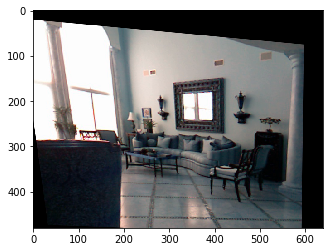

In [46]:
imshow(stableFrames[27])

In [6]:
def drawMatches(image1, image2, kps1, kps2, matches):
    # initialize the output visualization image
    (h1, w1) = image1.shape[:2]
    (h2, w2) = image2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
    vis[0:h1, 0:w1] = image1
    vis[0:h2, w1:] = image2
    
    pointsx1 = kps1[0]
    pointsy1 = kps1[1]
    pointsx2 = kps2[0]
    pointsy2 = kps2[1]
    points1 = []
    points2 = []
    

    # loop over the matches
    for i in range(len(matches)):
        # draw the match
        dm_l = matches[i]
        dm = dm_l[0]
        queryIdx = dm.queryIdx
        trainIdx = dm.trainIdx
        
        pt1 = (int(pointsx1[queryIdx]), int(pointsy1[queryIdx]))
        pt2 = (int(pointsx2[trainIdx]) + w1, int(pointsy2[trainIdx]))
        points1.append(pt1)
        points2.append(pt2)
        cv2.line(vis, pt1, pt2, (0, 255, 0), 1)

    # return the visualization
    return vis, np.array(points1), np.array(points2)

In [7]:
inputpath1 = "E:/Masterzz/5152-ComputerVision/Project/superpoint/SuperPointPretrainedNetwork/assets/icl_snippet/250.png"
inputpath2 = "E:/Masterzz/5152-ComputerVision/Project/superpoint/SuperPointPretrainedNetwork/assets/icl_snippet/302.png"

In [8]:
fe = SuperPointFrontend(weights_path='E:/Masterzz/5152-ComputerVision/Project/superpoint/SuperPointPretrainedNetwork/superpoint_v1.pth',
                      nms_dist=4,
                      conf_thresh=0.05,
                      nn_thresh=0.7,
                      cuda=False)

In [9]:
img1 = cv2.imread(inputpath1)
imgray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
imnorm1 = imgray1.astype('float32')
imnorm1.dtype
pts1, desc1, heatmap1 = fe.run(imnorm1/255.0)

img2 = cv2.imread(inputpath2)
imgray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
imnorm2 = imgray2.astype('float32')
imnorm2.dtype
pts2, desc2, heatmap2 = fe.run(imnorm2/255.0)

In [10]:
img1.shape

(480, 640, 3)

In [11]:
pTracker = PointTracker(2,0.7)

In [12]:
matchesSP = pTracker.nn_match_two_way(desc1, desc2, 0.4)

In [13]:
matchesSP.shape

(3, 96)

In [14]:
'''
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

matcher = cv2.FlannBasedMatcher(index_params, search_params)
#matcher = cv2.BFMatcher()

matches = matcher.knnMatch(desc2,desc1,k=2)

matchesMask = [[0,0] for i in range(len(matches))]

matchesFiltered = []
for i,(m,n) in enumerate(matches):
    print("m dist: "+str(m.distance)+"    n dist: "+str(n.distance))
    if m.distance < n.distance * 0.95 :
        matchesMask[i] = [1,0]
        matchesFiltered.append([m])
'''

'\nFLANN_INDEX_KDTREE = 0\nindex_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)\nsearch_params = dict(checks=50)\n\nmatcher = cv2.FlannBasedMatcher(index_params, search_params)\n#matcher = cv2.BFMatcher()\n\nmatches = matcher.knnMatch(desc2,desc1,k=2)\n\nmatchesMask = [[0,0] for i in range(len(matches))]\n\nmatchesFiltered = []\nfor i,(m,n) in enumerate(matches):\n    print("m dist: "+str(m.distance)+"    n dist: "+str(n.distance))\n    if m.distance < n.distance * 0.95 :\n        matchesMask[i] = [1,0]\n        matchesFiltered.append([m])\n'

In [15]:
key_ps1 = []
key_ps2 = []
for i in range(pts1.shape[1]):
    key_ps1.append(cv2.KeyPoint(pts1[0][i], pts1[1][i], _size=5, _response=1, _octave=0, _class_id=0))

for i in range(pts1.shape[1]):
    key_ps2.append(cv2.KeyPoint(pts2[0][i], pts2[1][i], _size=5, _response=1, _octave=0, _class_id=1))


In [16]:
dMatchesSP = []
for i in range(matchesSP.shape[1]):
    dmatch = cv2.DMatch()
    dmatch.queryIdx=int(matchesSP[1][i])
    dmatch.trainIdx=int(matchesSP[0][i])
    dmatch.distance=matchesSP[2][i]
    dMatchesSP.append([dmatch])

In [17]:
vis, points2, points1 = drawMatches(image1=img2, image2=img1, kps1=pts2, kps2=pts1,matches=dMatchesSP)

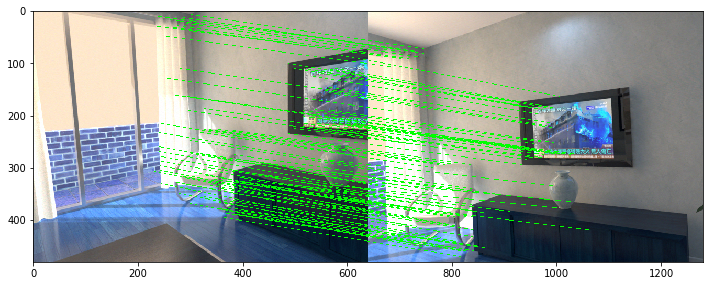

In [18]:
fig = figure(figsize = (12,8))
imshow(vis)

In [19]:
#fig = figure(figsize = (12,8))
#imshow(im2cir)

In [20]:
HG, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

In [21]:
stitched = cv2.warpPerspective(img2, HG, (img1.shape[1]+img2.shape[1], img2.shape[0]))

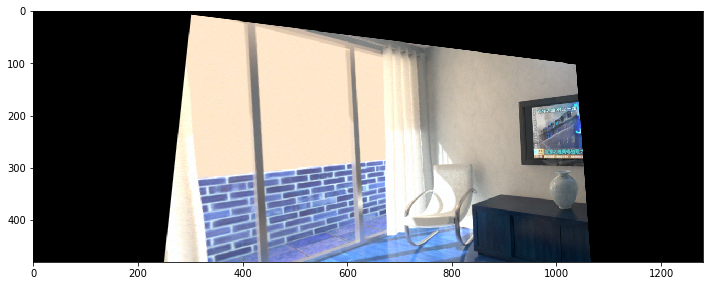

In [22]:
fig = figure(figsize = (12,8))
imshow(stitched)

In [23]:
stitched.shape

(480, 1280, 3)

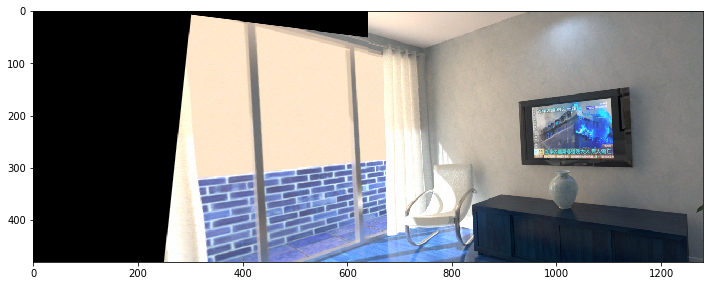

In [24]:
stitched[0:img1.shape[0], img2.shape[1]:] = img1
fig = figure(figsize = (12,8))
imshow(stitched)